Post-process the half-life scan results to build something to present at the IIPC GA.

* [Persistence of Web References in Scientific Research](http://clgiles.ist.psu.edu/papers/Computer-2001-web-references.pdf)
* [The Chesapeake Digital Preservation Group](http://cdm16064.contentdm.oclc.org/cdm/linkrot2014#linkrot2008)
* [What’s the average lifespan of a Web page?](http://jiscpowr.jiscinvolve.org/wp/2009/08/12/whats-the-average-lifespan-of-a-web-page/)
* [On the Web, Research Work Proves Ephemeral](http://web.archive.org/web/20111112053459/http://stevereads.com/cache/ephemeral_web_pages.html)
* [The Average Lifespan of a Webpage](http://blogs.loc.gov/digitalpreservation/2011/11/the-average-lifespan-of-a-webpage/)
* [Scholarly Context Not Found: One in Five Articles Suffers from Reference Rot](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0115253)
* [The Evanescent Web](http://blog.dshr.org/2015/02/the-evanescent-web.html)
* [How Much of the Web Is Archived?](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.211.397)
* [Profiling Web Archive Coverage for Top-Level Domain and Content Language](http://arxiv.org/pdf/1309.4008.pdf)
* [Profiling Web Archives](http://www.slideshare.net/phonedude/profiling-web-archives)


Generate visualisations
-------------------------

The following scripts take the results of the scan and generate suitable visualisations.


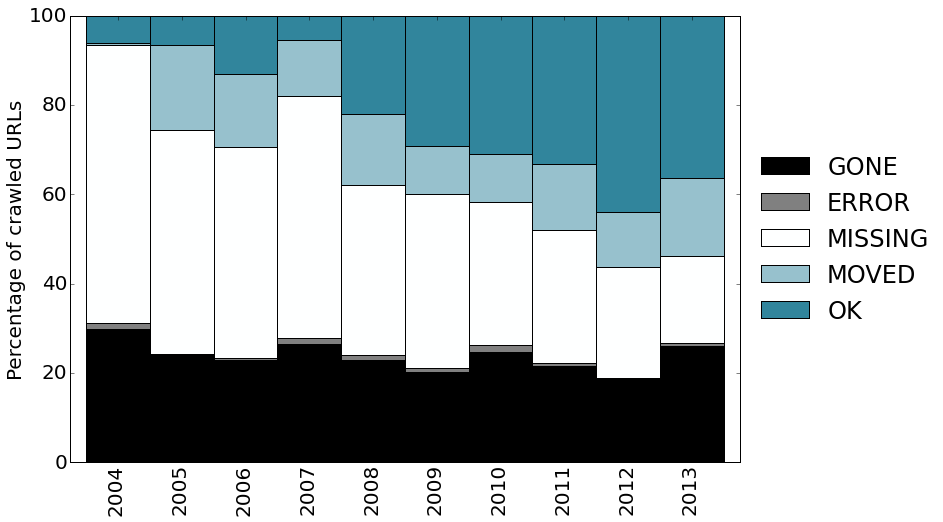

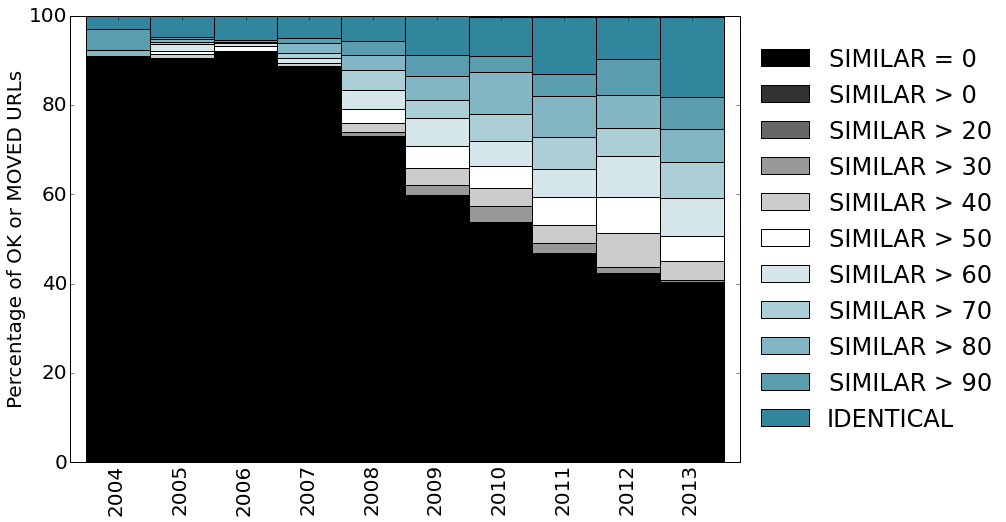

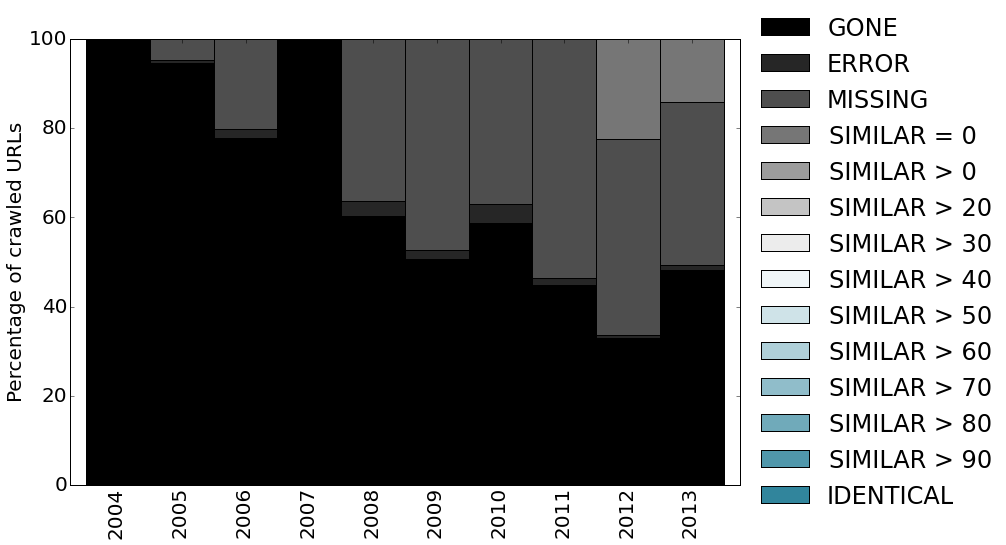

In [58]:
import csv, sys, pprint, datetime, os
import collections
import tldextract
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.rcParams['figure.figsize'] = 12, 8
matplotlib.rcParams.update({'font.size': 20, 'font.family':'Bitstream Vera Sans'})

plot_folder = "results"

def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

c = mcolors.ColorConverter().to_rgb
rvb = make_colormap(
    [c('black'), c('white'), 0.5, c('white'), (0.1922, 0.5216, 0.6118)])

def load(filename, colkey='year'):
    counts = collections.defaultdict(lambda: collections.defaultdict(int))
    totals = collections.defaultdict(int)
    with open(filename, 'r') as f:
        reader = csv.reader(f, delimiter="\t")
        for row in reader:
            tlds = tldextract.extract(row[8])
            # Fix suffix
            suffix = tlds.suffix
            if suffix.endswith(".sch.uk"):
                suffix = "sch.uk"
            elif suffix == "uk":
                suffix = tlds.registered_domain
            # Set up the key:
            if colkey == 'suffix':
                key = "."+suffix
            elif colkey == 'year-suffix':
                key = row[0]+"-."+suffix
            elif colkey == 'year-quarter':
                key = row[0]+"-"+row[1]
            else:
                key = row[0]
            counts[key]["TOTAL"] += 1
            counts[key][row[3]] += 1
            totals["TOTAL"] += 1
            totals[row[3]] += 1
            identical = row[6]
            similarity = row[7]
            if row[3] == "OK" or row[3] == "MOVED":
                if identical == "True":
                    counts[key]["IDENTICAL"] += 1
                    counts[key]["%s-IDENTICAL" % row[3]] += 1
                    totals["IDENTICAL"] += 1
                else:
                    if similarity != "None" and similarity != "" and int(similarity) > 0:
                        counts[key]["SIMILAR"] += 1
                        counts[key]["%s-SIMILAR" % row[3]] += 1
                        totals["SIMILAR"] += 1
                    else:
                        counts[key]["DISSIMILAR"] += 1  
                        counts[key]["%s-DISSIMILAR" % row[3]] += 1  
                        totals["DISSIMILAR"] += 1  
                    # Also record as histogram form
                    if similarity == "None" or similarity == "" or int(similarity) == 0:
                        counts[key]["SIMILAR = 0"] += 1
                        totals["SIMILAR = 0"] += 1
                    else:
                        simh = int(int(similarity)/10)*10
                        if simh == 0:
                            simh = 1
                        counts[key]["SIMILAR > %i" % simh] += 1
                        totals["SIMILAR > %i" % simh] += 1
    return counts,totals

def tabulate(filename):
    counts,totals = load(filename)
    pprint.pprint(counts)
    # Create the header line
    print("\t".join(['Year', 'GONE', 'ERROR', 'MISSING','MOVED','OK','DISSIM','SIMILAR','SAME','TOTAL']))
    for year in sorted(counts.keys()):
        # Now build up data
        line = year
        for state in ['GONE', 'ERROR', 'MISSING','MOVED','OK','DISSIMILAR','SIMILAR','IDENTICAL','TOTAL']:
            line = line + "\t" + str(counts[year][state])
            #line = line + "\t" + str(int(1000*counts[year][state]/counts[year]['TOTAL'])/10)
        print(line)
    line = "TOTAL"
    for state in ['GONE', 'ERROR', 'MISSING','MOVED','OK','DISSIMILAR','SIMILAR','IDENTICAL','TOTAL']:
        line = line + "\t" + str(int(1000*totals[state]/totals['TOTAL'])/10)
    print(line)

def stack(filename, outname):
    counts,totals = load(filename)
    datas = []
    cols = ['GONE', 'ERROR', 'MISSING','MOVED','OK']#,'DISSIMILAR','SIMILAR','IDENTICAL']:
    years = sorted(counts.keys())
    for year in years:
        values = []
        for state in cols:
            val = (100.0*counts[year][state])/counts[year]['TOTAL']
            values.append(val)
        datas.append(values)
    # 
    df = pd.DataFrame(datas,index=years,columns=cols)
    ax = df.plot(kind='bar', width=1.0, stacked=True, colormap=rvb, edgecolor = "black", position=0.5);
    ax.set_ylabel("Percentage of crawled URLs")
    #ax = df.plot(kind='pie', subplots=True, colormap='coolwarm_r');
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
    #plt.tight_layout()
    plt.savefig("%s/stack-%s.pdf" % (plot_folder, outname),bbox_inches='tight')
    plt.show()

def stack_sim(filename, outname):
    counts,totals = load(filename)
    datas = []
    cols = ['GONE', 'ERROR', 'MISSING',
          'SIMILAR = 0',
          'SIMILAR > 0',
          'SIMILAR > 20',
          'SIMILAR > 30',
          'SIMILAR > 40',
          'SIMILAR > 50',
          'SIMILAR > 60',
          'SIMILAR > 70',
          'SIMILAR > 80',
          'SIMILAR > 90',
           'IDENTICAL']
    years = sorted(counts.keys())
    for year in years:
        values = []
        for state in cols:
#            val = (100.0*counts[year][state])/counts[year]['TOTAL']
            val = (100.0*counts[year][state])/(counts[year]['OK']+counts[year]['MOVED'])
            values.append(val)
        datas.append(values)
    # 
    df = pd.DataFrame(datas,index=years,columns=cols)
    ax = df.plot(kind='bar', width=1.0, stacked=True, colormap=rvb, edgecolor = "black", position=0.5);
    #ax = df.plot(kind='pie', subplots=True, colormap='coolwarm_r');
    ax.set_ylabel("Percentage of crawled URLs")
    ax.set_ylim([0,100])
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
    #plt.tight_layout()
    plt.savefig("%s/stack-sim-%s.pdf" % (plot_folder, outname),bbox_inches='tight')
    plt.show()
    
def stack_sim_only(filename, outname):
    counts,totals = load(filename)
    datas = []
    cols = [
          'SIMILAR = 0',
          'SIMILAR > 0',
          'SIMILAR > 20',
          'SIMILAR > 30',
          'SIMILAR > 40',
          'SIMILAR > 50',
          'SIMILAR > 60',
          'SIMILAR > 70',
          'SIMILAR > 80',
          'SIMILAR > 90',
           'IDENTICAL']
    years = sorted(counts.keys())
    for year in years:
        values = []
        for state in cols:
            val = (100.0*counts[year][state])/(counts[year]['OK']+counts[year]['MOVED'])
            values.append(val)
        datas.append(values)
    # 
    df = pd.DataFrame(datas,index=years,columns=cols)
    ax = df.plot(kind='bar', width=1.0, stacked=True, colormap=rvb, edgecolor = "black", position=0.5);
    ax.set_ylim([0,100])
    ax.set_ylabel("Percentage of OK or MOVED URLs")
    #ax = df.plot(kind='pie', subplots=True, colormap='coolwarm_r');
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
    #plt.tight_layout()
    plt.savefig("%s/stack-sim-only-%s.pdf" % (plot_folder, outname),bbox_inches='tight')
    plt.show()
    
    
# Data before fixing query-string problem:
#tabulate("sample-scan-results/2015-03-31-TalkTalk/ldwa-sample-of-2000-scan-results.csv")
#print("---")

# Data after adding http://example.com/XXXRNDXXX/ soft-4xx check and fixing query-string problem.
#tabulate("sample-scan-results/2015-04-17-BL-WiFi/ldwa-sample-of-2000-scan-results.csv")
#print("---")

#tabulate("sample-scan-results/2015-04-17-TalkTalk/ldwa-sample-of-2000-scan-results.csv")
#print("---")
#print("---")

#in_file = "sample-scan-results/2015-04-19-Explorer/sample-of-1000-scan-results.csv"
in_file = "sample-scan-results/2015-09-Explorer/oukwa-sample-of-1000-scan-results.csv"
#tabulate(in_file)
stack(in_file,"oukwa")
stack_sim_only(in_file,"oukwa")
stack_sim(in_file,"oukwa")

# Only three soft-404s. Manual checking revealed at least one missed soft 404.
# Some sites are soft-404 but going all the way to the root hits a different handler.
# e.g. http://www.thesouthernreporter.co.uk/property/agent-search/40878
#
# Try alternative random-query generator to make soft-404 check more robust.
# Just appending to the path.

#tabulate("sample-scan-results/2015-04-17-TalkTalk-2/ldwa-sample-of-2000-scan-results.csv")

# But often trailing path is ignored! e.g.
# http://www.newstatesman.com/node/138986
# The removing a letter and appendings.

#tabulate("sample-scan-results/2015-04-18-TT/ldwa-sample-of-2000-scan-results.csv")

# But even that fails! e.g.
# http://www.westburytownforums.co.uk/index.php/topic,3861.msg45207.html
# So, instead, we replace the final path segment with a random string.
# That appears to give acceptable results. Although there are some false-positives:
# http://www.standard.co.uk/topic/Rum (96)
# http://bma.org.uk/news-views-analysis/the-bma-blog/tag/nhs-watch (99!)
# Very 'busy' pages with not much content difference get missed.

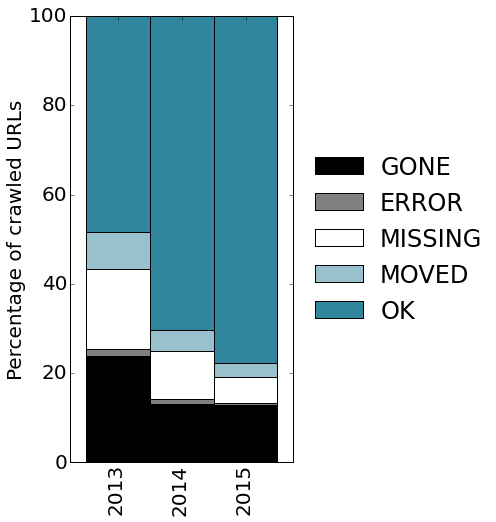

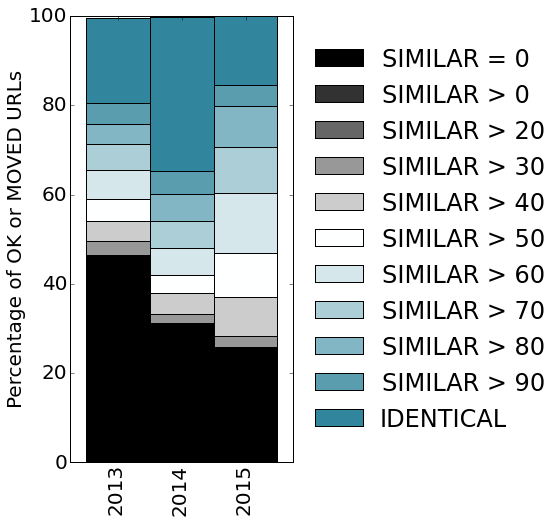

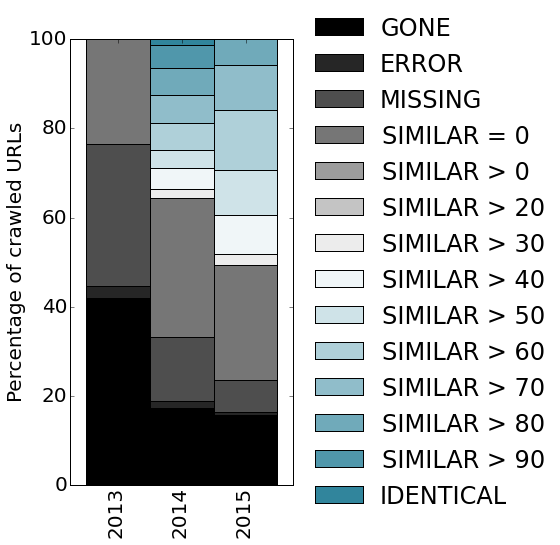

In [53]:

data_folder = datetime.datetime.now().strftime("sample-scan-results/%Y-%m-Explorer")
plot_folder = data_folder+"/results"

if not os.path.exists(plot_folder):
    os.mkdir(plot_folder)

plt.rcParams['figure.figsize'] = 4, 8
ldwa_file = data_folder+"/ldwa-sample-of-2000-scan-results.csv"
stack(ldwa_file,"ldwa")
stack_sim_only(ldwa_file,"ldwa")
stack_sim(ldwa_file,"ldwa")


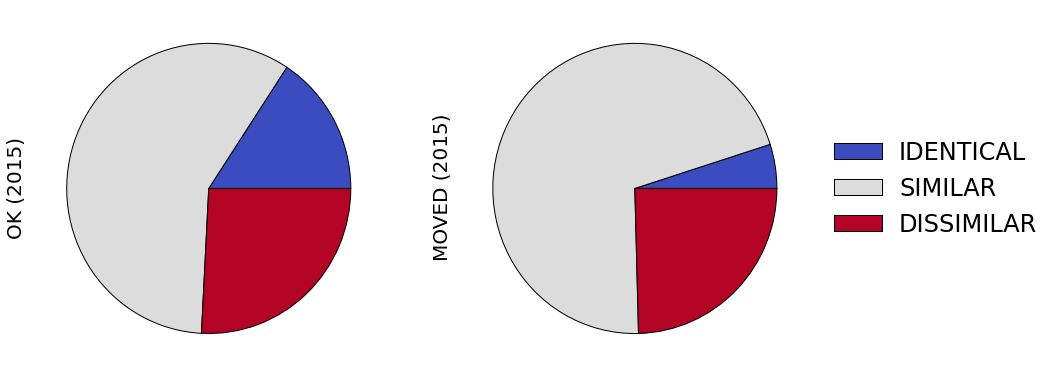

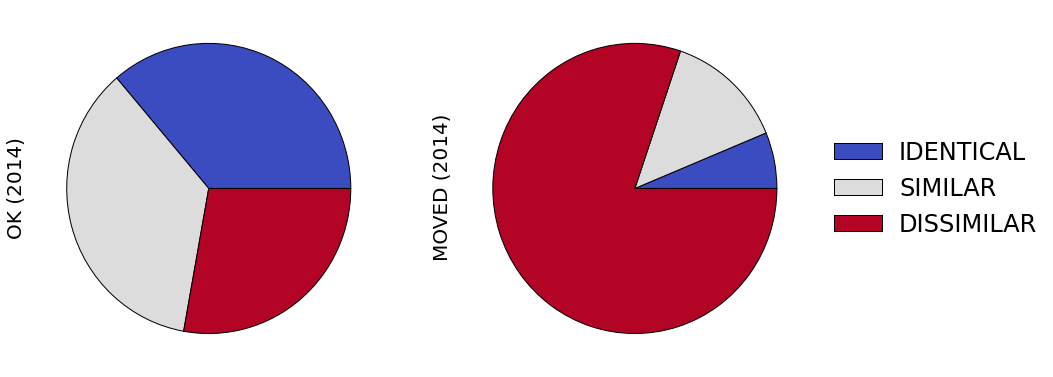

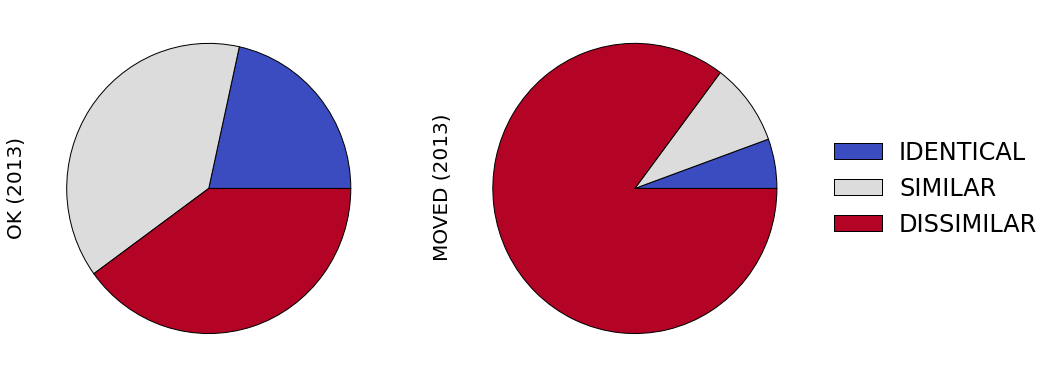

In [54]:
def ok_v_moved(filename, year, outname):
    counts,totals = load(filename)
    data = []
    index = []
    for state in ['IDENTICAL','SIMILAR','DISSIMILAR']:
        data.append((counts[year]['OK-'+state],counts[year]['MOVED-'+state]))
        index.append(state)
    d = pd.DataFrame(data, index=index, columns=['OK (%s)' % year, 'MOVED (%s)' %year])
    ax = d.plot(kind='pie', subplots=True, figsize=(14, 6.5), legend=False, fontsize=2, 
                textprops={'alpha':0}, colormap='coolwarm')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
    plt.savefig("%s/ok-v-moved-%s.pdf" % (plot_folder, outname),bbox_inches='tight')


ok_v_moved(ldwa_file,'2015',"ldwa")
ok_v_moved(ldwa_file,'2014',"ldwa")
ok_v_moved(ldwa_file,'2013',"ldwa")


tabulate("sample-scan-results/2015-04-17-TalkTalk/ldwa-sample-of-2000-scan-results.csv")

http://www.newstatesman.com/node/138986
http://www.newstatesman.com/node/138986FBDSGSFDGSDG



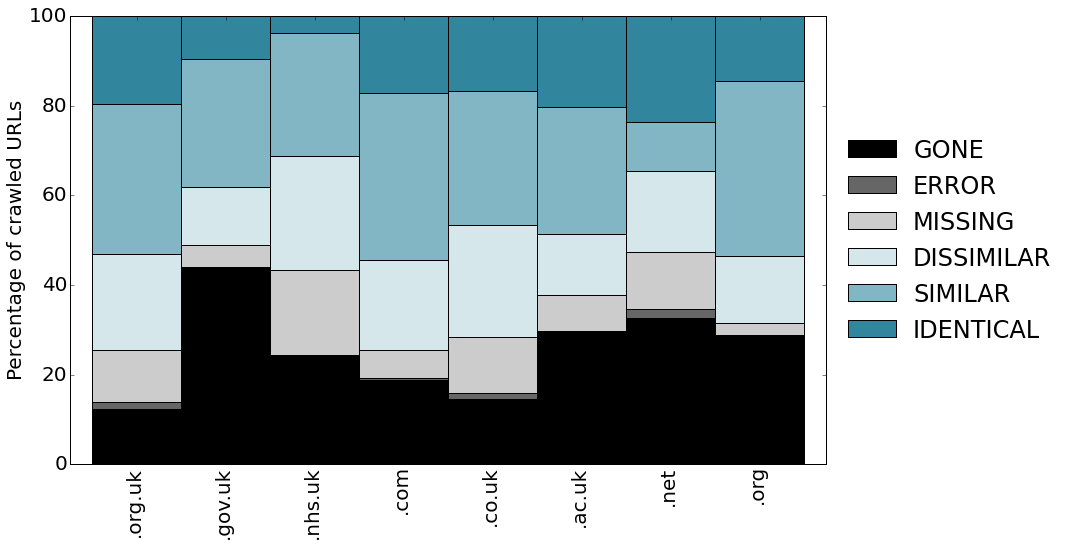

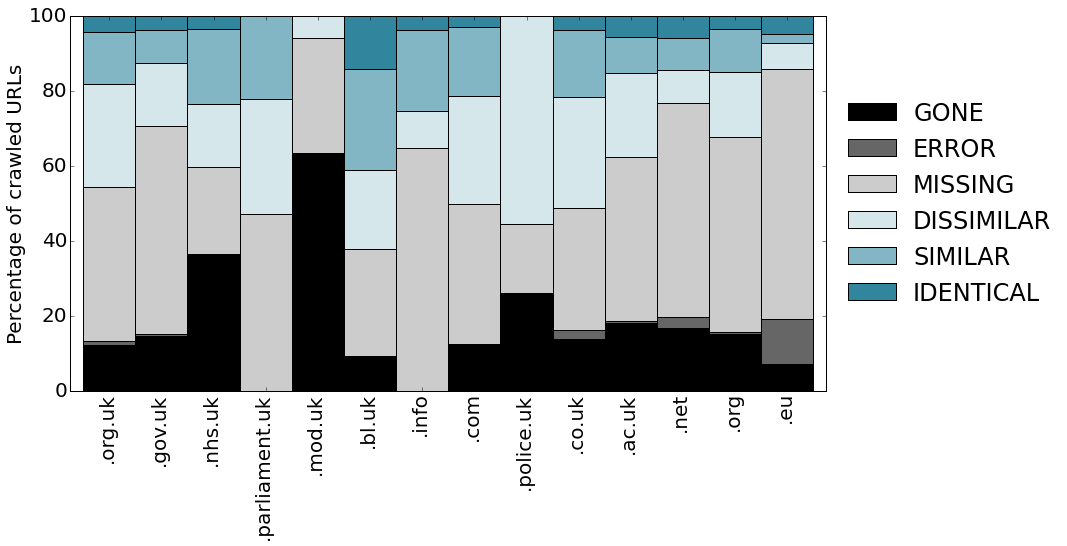

In [55]:
from collections import OrderedDict

def by_suffix(filename,outname):
    counts,totals = load(filename,'suffix')
    # Sort
    ocounts = OrderedDict(sorted(counts.items(), key=lambda x:(x[1]['IDENTICAL']+x[1]['SIMILAR'])/x[1]['TOTAL'], reverse=False))
    # Collect
    datas = []
    #cols = ['GONE', 'ERROR', 'MISSING','MOVED','OK']
    cols = ['GONE', 'ERROR', 'MISSING', 'DISSIMILAR','SIMILAR','IDENTICAL']
    domains = []
    for year in list(ocounts.keys()):
        if int(counts[year]['TOTAL']) > 25:
            domains.append(year)
            values = []
            for state in cols:
                val = (100.0*counts[year][state])/counts[year]['TOTAL']
                values.append(val)
            datas.append(values)
    # 
    df = pd.DataFrame(datas,index=domains,columns=cols)
    ax = df.plot(kind='bar', width=1.0, stacked=True, colormap=rvb, edgecolor = "black");
    ax.set_ylim([0,100])
    ax.set_ylabel("Percentage of crawled URLs")
    #ax = df.plot(kind='pie', subplots=True, colormap='coolwarm_r');
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
    plt.tight_layout()
    plt.savefig("%s/stack-domain-%s.pdf" % (plot_folder,outname),bbox_inches='tight')
    plt.show()


plt.rcParams['figure.figsize'] = 12, 8

by_suffix(ldwa_file,'ldwa')
by_suffix(in_file,'ukwa')


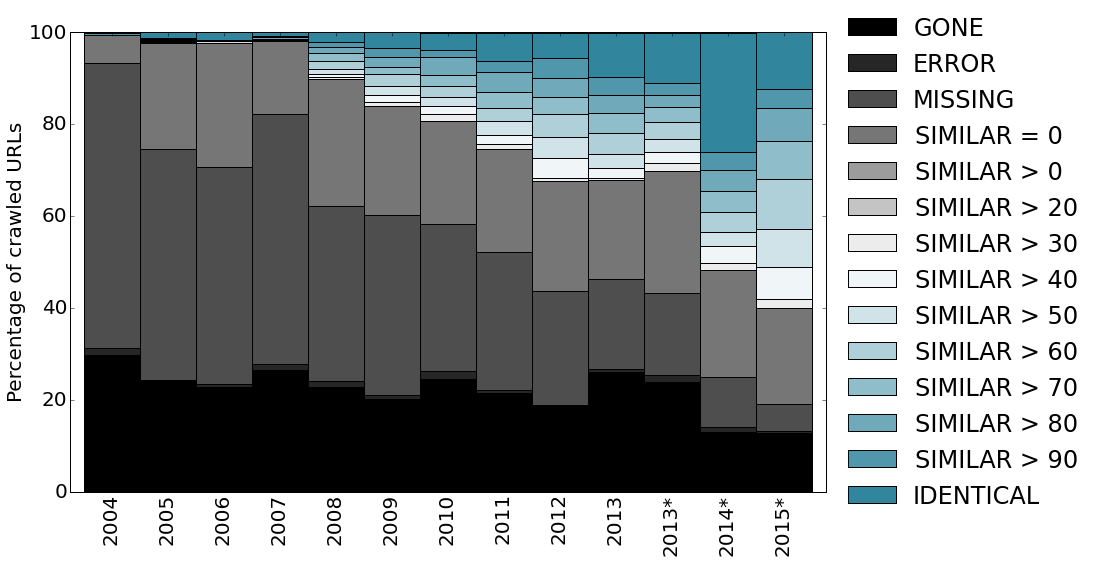

In [59]:
def stack_sim_2(filename,filename2, outname):
    counts,totals = load(filename)
    counts2,totals2 = load(filename2)
    counts['2013*'] = counts2['2013']
    counts['2014*'] = counts2['2014']
    counts['2015*'] = counts2['2015']
    datas = []
    cols = ['GONE', 'ERROR', 'MISSING',
          'SIMILAR = 0',
          'SIMILAR > 0',
          'SIMILAR > 20',
          'SIMILAR > 30',
          'SIMILAR > 40',
          'SIMILAR > 50',
          'SIMILAR > 60',
          'SIMILAR > 70',
          'SIMILAR > 80',
          'SIMILAR > 90',
           'IDENTICAL']
    years = sorted(counts.keys())
    for year in years:
        values = []
        for state in cols:
            val = (100.0*counts[year][state])/counts[year]['TOTAL']
#            val = 100*counts[year][state]/(counts[year]['OK']+counts[year]['MOVED'])
            values.append(val)
        datas.append(values)
    # 
    df = pd.DataFrame(datas,index=years,columns=cols)
    ax = df.plot(kind='bar', width=1.0, stacked=True, colormap=rvb, edgecolor = "black");
    #ax = df.plot(kind='pie', subplots=True, colormap='coolwarm_r');
    ax.set_ylabel("Percentage of crawled URLs")
    ax.set_ylim([0,100])
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
    plt.tight_layout()
    plt.savefig("%s/stack-sim-%s.pdf" % (plot_folder,outname),bbox_inches='tight')
    plt.show()
    
stack_sim_2(in_file,ldwa_file,"combined")